In [275]:
%matplotlib inline
import datetime
import os
import pandas as pd
import numpy as np
import sys
from jinja2 import Template
import  logging
sys.path.append('/Users/Mint/Desktop/repos/genie')

import matplotlib
matplotlib.use('TkAgg')
from imp import reload
import utils3.plotting as pl
import utils3.misc_utils as mu
import utils3.metrics as mt
import utils3.summary_statistics as ss
import utils3.feature_selection as fs
from utils3.data_io_utils import *
from utils3.data_io_utils import *
import utils3.modeling as ml
from functools import reduce
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [6]:
#reload(ml)
reload(mt)

<module 'utils3.metrics' from '/Users/Mint/Desktop/repos/genie\\utils3\\metrics.py'>

In [7]:
data_path = 'D:/Model/201908_qsfq_model/01_data'
result_path = 'D:/Model/201908_qsfq_model/02_result/'

In [30]:
x_with_y4 = pd.read_excel(os.path.join(data_path, 'x_with_y_v4.xlsx'))

x_with_y2 = x_with_y4.loc[x_with_y4.sample_set != 'train_new']
x_with_y2.index = x_with_y2.order_no

In [9]:
var_dict = pd.read_excel('D:/Model/201908_qsfq_model/建模代码可用变量字典.xlsx')


In [31]:
set(x_with_y2.columns) - set(var_dict.指标英文.unique())
x_cols = list(set(x_with_y2.columns).intersection(set(var_dict.指标英文.unique())))
len(x_cols)

309

In [32]:
y_cols = list(set(x_with_y2.columns) - set(var_dict.指标英文.unique()))
len(y_cols)


19

In [33]:
x_with_y2[x_cols] = x_with_y2[x_cols].astype(float)


In [34]:
"""
划分训练&验证
"""

x_with_y2.perf_flag.value_counts(dropna = False)

data_train = x_with_y2[x_with_y2.sample_set == 'train']
data_test = x_with_y2[x_with_y2.sample_set == 'test']
data_test_new = x_with_y2[x_with_y2.sample_set == 'test_new']

In [35]:
x_with_y2.perf_flag.value_counts()

0    5517
1    1375
9    1157
Name: perf_flag, dtype: int64

In [27]:
x_with_y2 = x_with_y2.replace(-8887,-1)

In [18]:
"""
EDA
"""

'\nEDA\n'

In [23]:
result_path

'D:/Model/201908_qsfq_model/02_result/'

In [36]:
X = x_with_y2.loc[x_with_y2.sample_set.isin(['train','test'])][x_cols]

In [37]:
ss.eda(X, var_dict, useless_vars=[], exempt_vars=[],\
       data_path=result_path, save_label='all')

In [38]:
summary = pd.read_excel(os.path.join('D:/Model/201908_qsfq_model/02_result/all_variables_summary.xlsx'), encoding='utf-8')
exclude_after_eda = summary.loc[summary.exclusion_reason.notnull(), '指标英文'].tolist()
len(exclude_after_eda)

78

In [152]:
x_with_y2 = x_with_y2.drop(exclude_after_eda,1)

In [153]:
x_with_y2.columns

Index(['effective_date', 'fid7', 'flag_credit', 'flag_fraud', 'order_no',
       'blacklist_flag', 'zq_blacklist', 'shumeimaxoverduelevel_flag',
       'xinyanadviceblack', 'tianyuriskcode2',
       ...
       'TSJY043', 'TSJY047', 'TSJY033', 'RMS002_RMS003', 'TSJY020', 'YLZC297',
       'YLZC013', 'YLZC035', 'YLZC037', 'YLZC053'],
      dtype='object', length=250)

In [154]:
x_with_y2.index = x_with_y2.order_no

In [155]:
x_with_y2.head()

,effective_date,fid7,flag_credit,flag_fraud,order_no,blacklist_flag,zq_blacklist,shumeimaxoverduelevel_flag,xinyanadviceblack,tianyuriskcode2,...,TSJY043,TSJY047,TSJY033,RMS002_RMS003,TSJY020,YLZC297,YLZC013,YLZC035,YLZC037,YLZC053
order_no,,,,,,,,,,,,,,,,,,,,,
CP2019010714501755695780,2019-01-07,-1,0,0,CP2019010714501755695780,-1,-1,-1,-1,-1,...,14.0,16.0,4.0,1.0,15.0,10.0,4.0,3.0,11.0,7.0
CP2019010816372829722750,2019-01-08,-1,0,0,CP2019010816372829722750,-1,-1,-1,-1,-1,...,3.0,4.0,0.0,40.0,35.0,13.0,3.0,3.0,12.0,7.0
CP2019010818542223493551,2019-01-09,-1,9,9,CP2019010818542223493551,-1,-1,-1,-1,-1,...,13.0,26.0,0.0,2.0,1.0,10.0,4.0,3.0,12.0,9.0
CP2019010608590656256549,2019-01-07,-1,9,9,CP2019010608590656256549,-1,-1,-1,-1,-1,...,3.0,3.0,0.0,24.0,2.0,6.0,6.0,2.0,2.0,3.0
CP2019011312371904497201,2019-01-14,-1,9,9,CP2019011312371904497201,-1,-1,-1,-1,-1,...,10.0,12.0,0.0,5.0,13.0,5.0,3.0,3.0,11.0,3.0


In [156]:
"""
样本划分
"""
#
#train
X_train_df = x_with_y2.loc[(x_with_y2.perf_flag.isin([0,1])) & (x_with_y2.sample_set == 'train')].drop(y_cols,1)
y_train_df = x_with_y2.loc[x_with_y2.perf_flag.isin([0,1]) & (x_with_y2.sample_set == 'train')].perf_flag
#y_train_df = pd.DataFrame(y_train_df)

#X_train_df.shape #2264
y_train_df.shape




(2264,)

In [319]:
#test
X_test_df = x_with_y2.loc[x_with_y2.sample_set == 'test'].drop(y_cols,1)

y_test_df = x_with_y2.loc[x_with_y2.sample_set == 'test'].perf_flag.replace(9,0)
X_test_df.shape #1250
y_test_df.shape
# #test new
# X_test_df_new = data_test_new.drop(y_cols,1)[td_cols]
# y_test_df_new = data_test_new.perf_flag

#X_test_df_new.shape #3723



(1250,)

In [158]:
#
X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
X_test.shape
y_test = y_test_df.values

# X_test_new = X_test_df_new.values
# X_test_new.shape
# y_test_new = y_test_df_new.values

In [159]:
X_train_df.shape

(2264, 231)

In [160]:
"""
IV
"""
args_dict = {
    'random_forest': {
        'grid_search': False,#选择了True则会进行网格筛选速度会比较慢
        'param': None
    },
    'xgboost': {
        'grid_search': False,
        'param': None
    }
}
methods = [
    #'random_forest',
    #'lasso',
    #'xgboost'
]

fs_obj = fs.FeatureSelection()
logging.basicConfig(filename=os.path.join(result_path, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)


X_cat_train,X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_train_df, y_train_df, var_dict, args_dict, methods, num_max_bins=5)


In [49]:

result_path

'D:/Model/201908_qsfq_model/02_result/'

In [161]:
woe_iv_df.to_excel(os.path.join(result_path,'woe_iv_df.xlsx'))
ranking_result.to_excel(os.path.join(result_path,'ranking_result.xlsx'))
save_data_to_pickle(rebin_spec,result_path,'rebin_spec.pkl')

In [162]:
save_data_to_pickle(X_cat_train,result_path,'X_cat_train.pkl')

In [163]:
rebin_spec = mu.convert_rebin_spec2XGB_rebin_spec(rebin_spec)

In [ ]:
"""
变量筛选
"""

In [164]:
# 确定需要留下的排名靠前变量的数量
n = 300
top_n = ranking_result.sort_values('overall_rank')[u'指标英文'].iloc[:n].tolist()

In [165]:
# 决定从top_n中剔除的字段名称
exclusion = []
# 决定模型一定要有的字段，即使可能不显著
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

In [166]:
# 将数据分箱后并转换woe值
X_transformed_train = X_transformed
# clean data
X_transformed_train = X_transformed_train[selected]

In [167]:
"""
相关性
"""
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity(X_transformed_train,result_path)

In [168]:
vif_result.run(ranking_result)

In [170]:
# 相关性分析删除的变量
exclusion_cols = vif_result.corr_exclude_vars + vif_result.vif_dropvars

In [171]:
len(exclusion_cols)

158

In [65]:
"""
调整粗分箱
"""


'\n调整粗分箱\n'

In [172]:
selected = list(set(selected) - set(exclusion_cols))
len(selected)

73

In [173]:
ui_obj = pl.BinPlotAdjustUI(X_train_df, y_train_df, result_path,data_path,rebin_spec, var_dict)
ui_obj.main_ui(selected)

In [174]:
rebin_spec_bin_adjusted = {k:v for k,v in ui_obj.rebin_spec.items() if k in selected}

In [175]:
save_data_to_pickle(rebin_spec_bin_adjusted,result_path,'rebin_spec_bin_adjusted.pkl')

In [86]:
"""
训练集按照新的rebin_spec进行分箱
"""

'\n训练集按照新的rebin_spec进行分箱\n'

In [176]:
#apply new bin cutting to the data
bin_obj = mt.BinWoe()
new_X = X_train_df[selected]
X_cat_train = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all(X_cat_train, y_train_df, var_dict, rebin_spec_bin_adjusted)

In [177]:
new_X = X_test_df[selected]
X_cat_test = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)

In [ ]:
"""
将变量转化为XGBoost需要的形式
"""

In [178]:
selected_final = selected
len(selected_final)

73

In [179]:
rebin_spec_bin_adjusted_final = {k:v for k,v in rebin_spec.items() if k in selected_final}

In [118]:
# # 依旧建议吧完成的结果存出去，保证后续挂掉以后也能不用重头再来
# save_data_to_pickle(rebin_spec_bin_adjusted,Result_path,'rebin_spec_bin_adjusted.pkl')

In [ ]:
"""
将训练集数据进行XGboost转换
"""

In [180]:
X_train_final = X_train_df[selected_final]
X_cat_train_final = X_cat_train[selected_final]

In [181]:
X_train_final.shape

(2264, 73)

In [182]:
reload(mt)
bin_obj = mt.BinWoe()

In [183]:
# X_train_xgboost:xgboost最终衍生完成的所有变量的集合
# rebin_spec_bin_adjusted_final:最终的分箱文件
# bin_to_label:将分箱转化为标签的dict文件
# dummy_var_name_map:转化为dummy的dict文件
X_train_xgboost, rebin_spec_bin_adjusted_final, bin_to_label, dummy_var_name_map =\
bin_obj.xgboost_data_derive(X_train_final, y_train_df, var_dict\
                            ,rebin_spec_adjusted=rebin_spec_bin_adjusted_final\
                            , verbose=True)

In [75]:
"""
将测试集进行XGboost转转换
"""

'\n将测试集进行XGboost转转换\n'

In [184]:
X_test_final = X_test_df[selected_final]
X_cat_test_final = X_cat_test[selected_final]

In [185]:
X_test_xgboost = mt.BinWoe().apply_xgboost_data_derive(X_test_final,
                                var_dict, rebin_spec_bin_adjusted_final, bin_to_label)

In [186]:
X_test_xgboost.columns

Index(['maritalstatus', 'r47580344_m_industry_1_ct', 'YLZC013',
       'm_12cnt_org_cc', 'r47580344_id_industry_6_ct', 'loans_credibility',
       'm_18cnt_org_cash', 'm_12cnt_org_cf', 'loans_long_time',
       'loans_overdue_count',
       ...
       'monthlyincome_binnum', 'd_30cnt_cf_binnum', 'm_12cnt_binnum',
       'm_18pct_cnt_org_cf_binnum', 'ty_riskcode_6_binnum',
       'm_12cnt_cf_binnum', 'd_60cnt_binnum', 'TSJY020_binnum',
       'm_9cnt_cf_binnum', 'd_30cnt_cash_binnum'],
      dtype='object', length=146)

In [187]:
X_train_xgboost.shape

(2264, 146)

In [188]:
train_bin_cols = [i for i in X_train_xgboost.columns if 'binnum' in i]
len(train_bin_cols)

73

In [189]:
test_bin_cols = [i for i in X_test_xgboost.columns if 'binnum' in i]
len(test_bin_cols)

73

In [281]:
train1_index, train2_index = train_test_split(X_train_xgboost_without_bin_dummy.index, train_size = 0.7)

In [279]:
len(train1_index)

1584

In [282]:
len(train2_index)

680

In [ ]:
X_train_xgboost_without_bin_dummy = X_train_xgboost.drop(train_bin_cols,1)
X_train_xgboost_without_bin_dummy.shaperain_xgboost_without_bin_dummy = X_train_xgboost.drop(train_bin_cols,1)
X_train_xgboost_without_bin_dummy.shape

In [292]:
X_train_wo_bin = X_train_xgboost_without_bin_dummy.loc[X_train_xgboost_without_bin_dummy.index.isin(train1_index)]
y_train_new = y_train_df.loc[y_train_df.index.isin(train1_index)]

X_train_wo_bin.shape; y_train_new.shape

(1584,)

In [293]:
X_test_wo_bin = X_train_xgboost_without_bin_dummy.loc[X_train_xgboost_without_bin_dummy.index.isin(train2_index)]
y_test_new = y_train_df.loc[y_train_df.index.isin(train2_index)]
X_test_wo_bin.shape; y_test_new.shape

(680,)

In [317]:
X_test_xgboost_without_bin_dummy = X_test_xgboost.drop(test_bin_cols,1)
X_test_xgboost_without_bin_dummy.shape

(1250, 73)

In [320]:
y_test_df.shape

(1250,)

In [222]:
X_test_xgboost_without_bin_dummy  = X_train_xgboost_without_bin_dummy.copy()
y_test_df  = y_train_df.copy()

In [295]:
X_train_wo_bin.shape

(1584, 73)

In [294]:
# 其中demo_xgb这个label很重要之后还会用到
save_data_to_pickle({
            'X_train_xgboost': X_train_wo_bin,
            'X_test_xgboost': X_test_wo_bin,
            'rebin_spec': rebin_spec_bin_adjusted_final,
            'bin_to_label': bin_to_label,
            'dummy_var_name_map': dummy_var_name_map}, data_path,\
        '%s_XGBoost输出数据和分箱明细.pkl' % 'demo_xgb')

In [133]:
"""
模型评估
"""

'\n模型评估\n'

In [353]:
# 调参方法，可自行选择
#xgbparams_selection_method = ['XGBExp', 'XGBRandom','XGBGrid']
xgbparams_selection_method = ['XGBExp']

In [256]:
# 随机调参时刻的相关参数
xgb_params_range = {
            'learning_rate': [0.03, 0.05,0.1,0.2],
            'max_depth': [2,3,4,5],
            'gamma': [0, 0.05, 0.1],
            'min_child_weight':[1,3],
            # 'subsample': np.linspace(0.4, 0.7, 3),
            # 'colsample_bytree': np.linspace(0.4, 0.7, 3),
        }

In [351]:
# 经验参数
xgb_param_experience = {
            'max_depth': 2,
            'min_samples_leaf ': 200,
             'eta': 0.1,
             'objective': 'binary:logistic',
             'subsample': 0.8,
             'colsample_bytree': 0.8,
             'gamma': 0,
             'silent': 0,
             'eval_metric':'auc'
              #'eval_metric':'precision'
        }

In [297]:
sample_split_summary = ss.sample_split_summary(y_train_new,y_test_new)
sample_split_summary

,split,total,good,bad,rate,dist
0,train,1584,966,618,0.390152,0.699647
1,test,680,401,279,0.410294,0.300353
2,sum,2264,1367,897,0.396201,1.000000


In [352]:
xgbmodel_obj = ml.XGBModel(var_dict, data_path, result_path,
                        'demo_xgb', y_train_new,
                        y_test= y_test_new,
                        params_selection_method=xgbparams_selection_method)

In [355]:
xgbparams_selection_method

['XGBExp']

In [354]:
xgbmodel_obj.run(xgb_params_range, xgb_param_experience, xgb_select=False)

[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.723551	test-auc:0.676255
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_de

[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

XGBoostError: b'[17:07:52] src/metric/metric.cc:21: Unknown metric function precision'

In [ ]:
"""
训练集和测试集拟合结果
"""

In [309]:
plot_obj = ml.LogisticModel(var_dict=var_dict, y_train=y_train_new,
                                    y_test=y_test_new)

In [310]:
y_test_new.shape

(680,)

(2264,)

In [ ]:
"""
查看XGBExp（经验参数）模型结果
"""

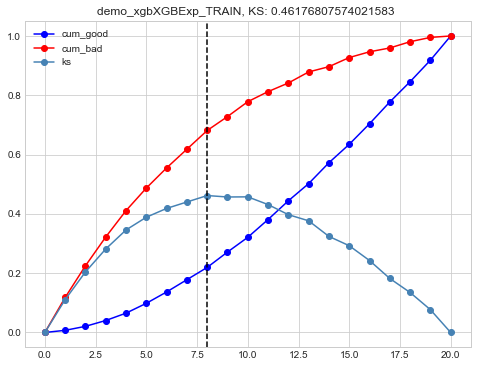

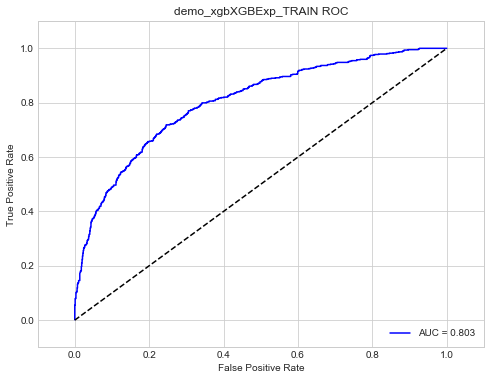

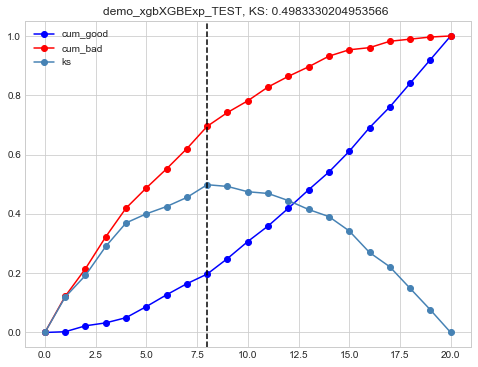

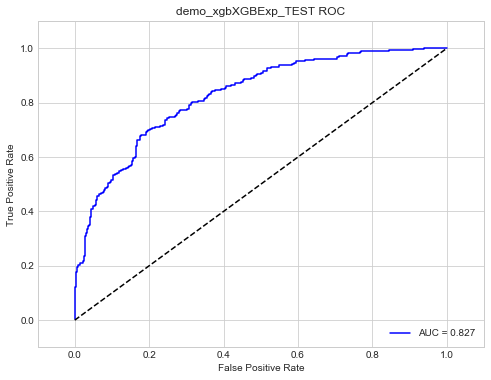

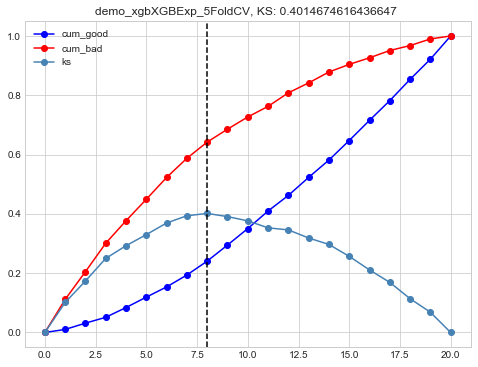

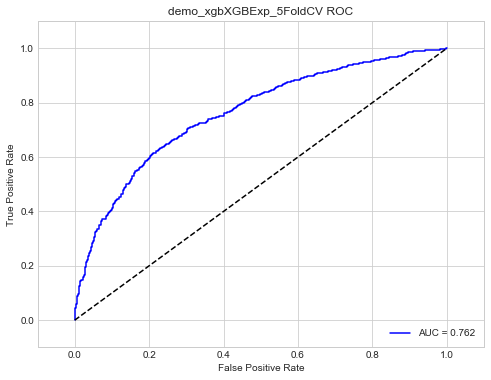

In [370]:
model_result_exp = load_data_from_pickle(data_path,
                '%s模型结果.pkl' % ('demo_xgb'+'XGBExp'))
plot_obj.plot_for_the_model(result_path, model_result_exp, with_test= True)

In [ ]:
"""
查看XGBExp（经验参数）对应的每一颗决策树的决策点
"""

In [202]:
model_result_exp['model_final'].dump_model(result_path+'/model_result_exp_trees.txt')

In [ ]:
"""
查看XGBRandom（随机参数）模型结果
"""

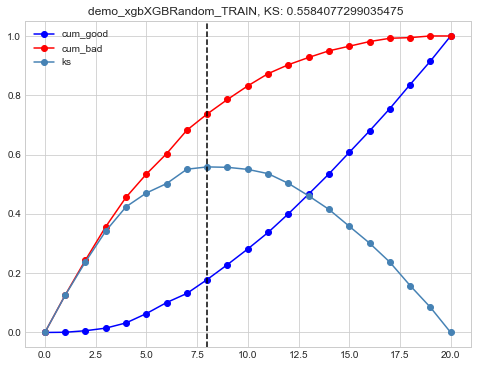

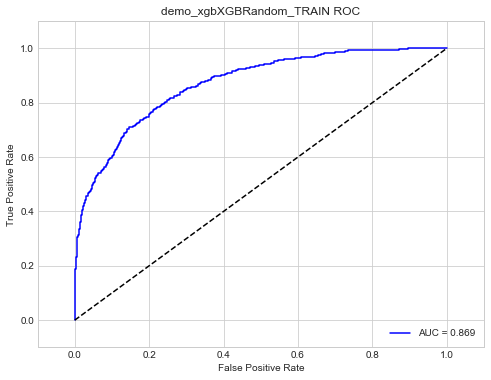

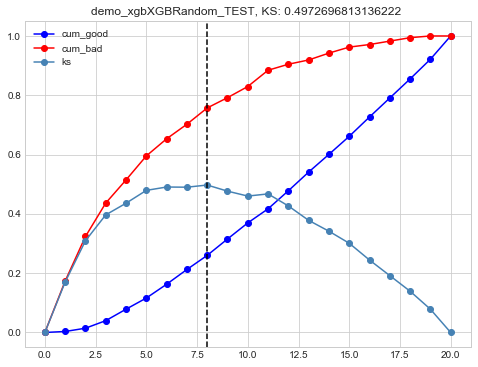

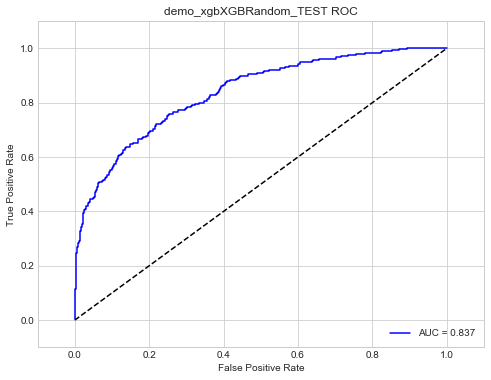

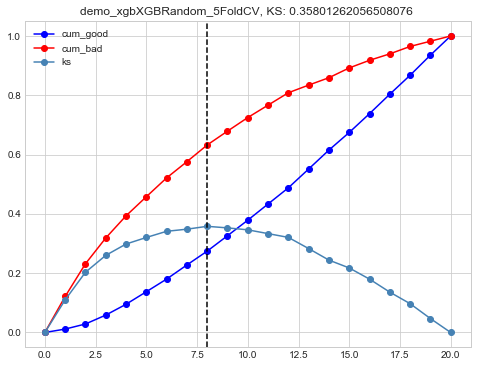

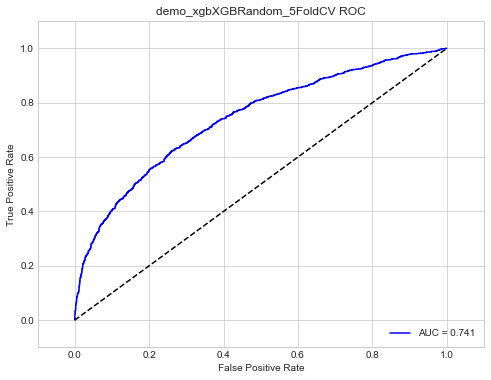

In [203]:
model_result_random = load_data_from_pickle(data_path,
                '%s模型结果.pkl' % ('demo_xgb'+'XGBRandom'))
plot_obj.plot_for_the_model(result_path, model_result_random, with_test=True)

In [204]:
model_result_random['model_final'].dump_model(result_path+'/model_result_random_trees.txt')

In [140]:
"""
查看XGBGrid（网格参数）模型结果
"""

'\n查看XGBGrid（网格参数）模型结果\n'

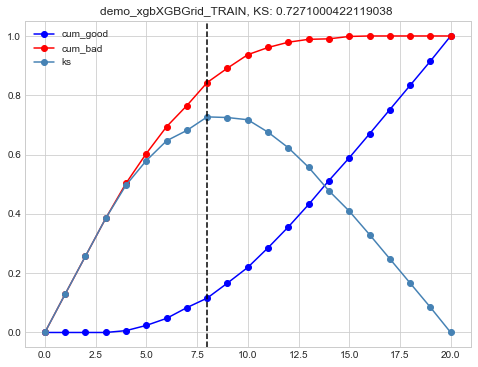

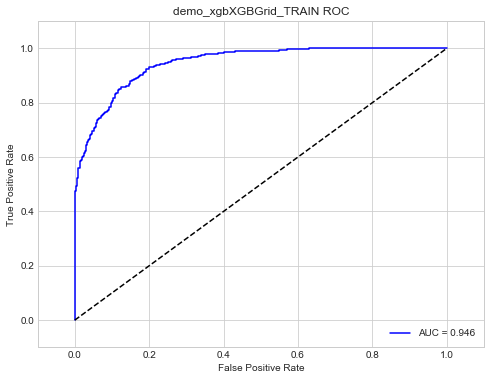

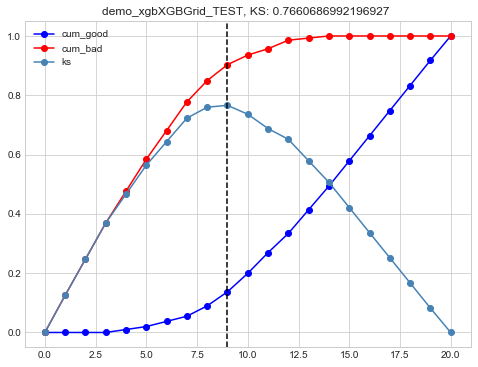

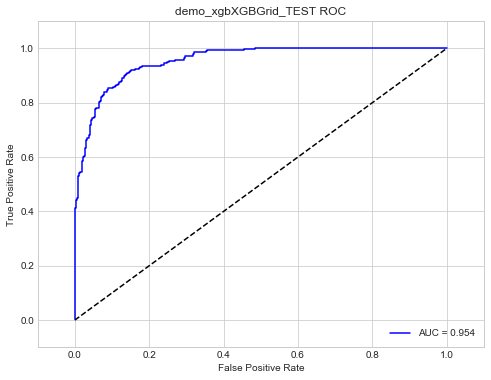

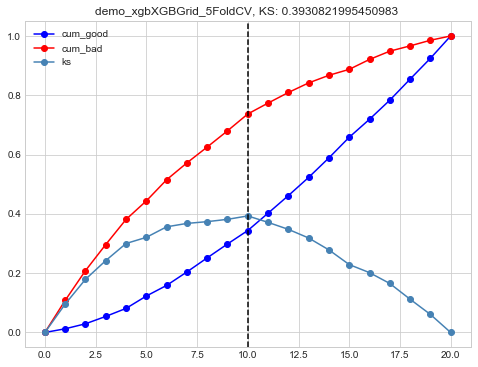

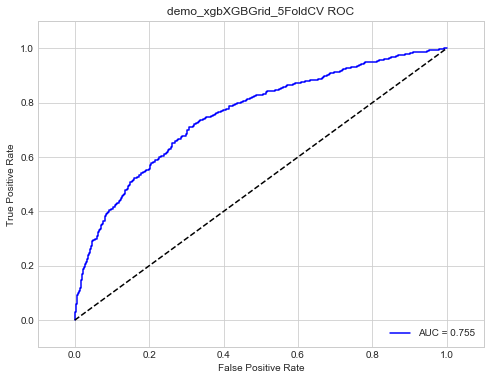

In [342]:
model_result_grid = load_data_from_pickle(data_path,
                '%s模型结果.pkl' % ('demo_xgb'+'XGBGrid'))
plot_obj.plot_for_the_model(result_path, model_result_grid, with_test=True)

In [ ]:
"""
查看decile和Runbook
"""

In [371]:
#查看XGBExp模型decile
train_XGBExp_score = model_result_exp['p_train'].apply(mt.Performance().p_to_score)
test_XGBExp_score = model_result_exp['p_test'].apply(mt.Performance().p_to_score)

In [372]:
train_XGBExp_score.shape

(1584,)

In [373]:
# 训练集
ks_decile_XGBExp_train = mt.Performance().calculate_ks_by_decile(train_XGBExp_score, np.array(y_train_new), 'decile', q=10)
ks_decile_XGBExp_train

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(530.0, 573.0]",161,20,141,0.875776,0.228155,0.020704,0.228155,0.020704,0.2075,0.1
1,"(573.0, 589.0]",165,47,118,0.715152,0.190939,0.048654,0.419094,0.069358,0.3497,0.4
2,"(589.0, 601.0]",162,71,91,0.561728,0.147249,0.073499,0.566343,0.142857,0.4235,0.8
3,"(601.0, 612.0]",157,82,75,0.477707,0.121359,0.084886,0.687702,0.227743,0.4600,1.1
4,"(612.0, 619.0]",161,102,59,0.366460,0.095469,0.105590,0.783172,0.333333,0.4498,1.7
5,"(619.0, 625.0]",163,121,42,0.257669,0.067961,0.125259,0.851133,0.458592,0.3925,2.9
6,"(625.0, 631.0]",151,119,32,0.211921,0.051780,0.123188,0.902913,0.581781,0.3211,3.7
7,"(631.0, 638.0]",150,122,28,0.186667,0.045307,0.126294,0.948220,0.708075,0.2401,4.4
8,"(638.0, 646.0]",172,150,22,0.127907,0.035599,0.155280,0.983819,0.863354,0.1205,6.8
9,"(646.0, 676.0]",142,132,10,0.070423,0.016181,0.136646,1.000000,1.000000,0.0000,13.2


In [374]:
# 测试集
point_bounds_XGBExp = mt.BinWoe().obtain_boundaries(ks_decile_XGBExp_train[u'分箱'])['cut_boundaries']
ks_decile_XGBExp_test = mt.Performance().calculate_ks_by_decile(test_XGBExp_score, np.array(y_test_new), 'decile', \
                                                         manual_cut_bounds=point_bounds_XGBExp)
ks_decile_XGBExp_test

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 573.0]",78,11,67,0.858974,0.240143,0.027431,0.240143,0.027431,0.2127,0.2
1,"(573.0, 589.0]",71,13,58,0.816901,0.207885,0.032419,0.448029,0.059850,0.3882,0.2
2,"(589.0, 601.0]",56,27,29,0.517857,0.103943,0.067332,0.551971,0.127182,0.4248,0.9
3,"(601.0, 612.0]",80,36,44,0.550000,0.157706,0.089776,0.709677,0.216958,0.4927,0.8
4,"(612.0, 619.0]",58,36,22,0.379310,0.078853,0.089776,0.788530,0.306733,0.4818,1.6
5,"(619.0, 625.0]",54,37,17,0.314815,0.060932,0.092269,0.849462,0.399002,0.4505,2.2
6,"(625.0, 631.0]",76,53,23,0.302632,0.082437,0.132170,0.931900,0.531172,0.4007,2.3
7,"(631.0, 638.0]",68,60,8,0.117647,0.028674,0.149626,0.960573,0.680798,0.2798,7.5
8,"(638.0, 646.0]",77,68,9,0.116883,0.032258,0.169576,0.992832,0.850374,0.1425,7.6
9,"(646.0, inf]",62,60,2,0.032258,0.007168,0.149626,1.000000,1.000000,0.0000,30.0


In [361]:
#查看XGBGrid模型decile
train_XGBGrid_score = model_result_grid['p_train'].apply(mt.Performance().p_to_score)
test_XGBGrid_score = model_result_grid['p_test'].apply(mt.Performance().p_to_score)

In [362]:
len(train_XGBGrid_score)

1584

In [345]:
# 训练集
ks_decile_XGBGrid_train = mt.Performance().calculate_ks_by_decile(train_XGBGrid_score, np.array(y_train_new), 'decile', q=10)
ks_decile_XGBGrid_train

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(507.0, 561.0]",160,0,160,1.000000,0.258900,0.000000,0.258900,0.000000,0.2589,0.000000
1,"(561.0, 582.0]",157,6,151,0.961783,0.244337,0.006211,0.503236,0.006211,0.4970,0.000000
2,"(582.0, 599.0]",166,44,122,0.734940,0.197411,0.045549,0.700647,0.051760,0.6489,0.400000
3,"(599.0, 611.0]",155,64,91,0.587097,0.147249,0.066253,0.847896,0.118012,0.7299,0.700000
4,"(611.0, 621.0]",160,103,57,0.356250,0.092233,0.106625,0.940129,0.224638,0.7155,1.800000
5,"(621.0, 629.0]",160,135,25,0.156250,0.040453,0.139752,0.980583,0.364389,0.6162,5.400000
6,"(629.0, 638.0]",170,164,6,0.035294,0.009709,0.169772,0.990291,0.534161,0.4561,27.300000
7,"(638.0, 647.0]",160,154,6,0.037500,0.009709,0.159420,1.000000,0.693582,0.3064,25.700000
8,"(647.0, 656.0]",139,139,0,0.000000,0.000000,0.143892,1.000000,0.837474,0.1625,inf
9,"(656.0, 690.0]",157,157,0,0.000000,0.000000,0.162526,1.000000,1.000000,-0.0000,inf


In [346]:
# 测试集
point_bounds_XGBGrid = mt.BinWoe().obtain_boundaries(ks_decile_XGBGrid_train[u'分箱'])['cut_boundaries']
ks_decile_XGBGrid_test = mt.Performance().calculate_ks_by_decile(test_XGBGrid_score, np.array(y_test_new), 'decile', \
                                                         manual_cut_bounds=point_bounds_XGBGrid)
ks_decile_XGBGrid_test

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 561.0]",77,0,77,1.000000,0.275986,0.000000,0.275986,0.000000,0.2760,0.000000
1,"(561.0, 582.0]",69,4,65,0.942029,0.232975,0.009975,0.508961,0.009975,0.4990,0.100000
2,"(582.0, 599.0]",78,15,63,0.807692,0.225806,0.037406,0.734767,0.047382,0.6874,0.200000
3,"(599.0, 611.0]",56,22,34,0.607143,0.121864,0.054863,0.856631,0.102244,0.7544,0.600000
4,"(611.0, 621.0]",70,48,22,0.314286,0.078853,0.119701,0.935484,0.221945,0.7135,2.200000
5,"(621.0, 629.0]",61,47,14,0.229508,0.050179,0.117207,0.985663,0.339152,0.6465,3.400000
6,"(629.0, 638.0]",65,61,4,0.061538,0.014337,0.152120,1.000000,0.491272,0.5087,15.200000
7,"(638.0, 647.0]",65,65,0,0.000000,0.000000,0.162095,1.000000,0.653367,0.3466,inf
8,"(647.0, 656.0]",62,62,0,0.000000,0.000000,0.154613,1.000000,0.807980,0.1920,inf
9,"(656.0, inf]",77,77,0,0.000000,0.000000,0.192020,1.000000,1.000000,0.0000,inf


In [ ]:
"""
OOT
"""

In [325]:
X_test_df.shape

(1250, 231)

In [375]:
#Exp
test_score = mt.Performance().calculate_score_by_xgb_model_result\
(X_test_xgboost_without_bin_dummy, model_result_exp)

In [376]:
pd.DataFrame(y_test_df).head()

,perf_flag
order_no,
CP2018122316040641486425,1
CP2019010515582704484981,1
CP2019010820150005663589,1
CP2019010822290927371439,0
CP2019010415513181322841,1


In [377]:
test_all = pd.merge(pd.DataFrame(y_test_df),test_score,left_index=True,right_index=True)

In [378]:
test_all.head()

,perf_flag,prob,xgbScore
order_no,,,
CP2018122316040641486425,1,0.369075,615.0
CP2019010515582704484981,1,0.733963,571.0
CP2019010820150005663589,1,0.851005,550.0
CP2019010822290927371439,0,0.247504,632.0
CP2019010415513181322841,1,0.718068,573.0


In [379]:
mt.Performance().calculate_ks_by_decile(test_all.xgbScore,test_all.perf_flag, 'decile', manual_cut_bounds=point_bounds_XGBExp)


perf_flag,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 573.0]",118,40,78,0.661017,0.225434,0.044248,0.225434,0.044248,0.1812,0.5
1,"(573.0, 589.0]",131,66,65,0.496183,0.187861,0.073009,0.413295,0.117257,0.2960,1.0
2,"(589.0, 601.0]",118,84,34,0.288136,0.098266,0.092920,0.511561,0.210177,0.3014,2.5
3,"(601.0, 612.0]",170,128,42,0.247059,0.121387,0.141593,0.632948,0.351770,0.2812,3.0
4,"(612.0, 619.0]",137,101,36,0.262774,0.104046,0.111726,0.736994,0.463496,0.2735,2.8
5,"(619.0, 625.0]",134,108,26,0.194030,0.075145,0.119469,0.812139,0.582965,0.2292,4.2
6,"(625.0, 631.0]",120,102,18,0.150000,0.052023,0.112832,0.864162,0.695796,0.1684,5.7
7,"(631.0, 638.0]",121,102,19,0.157025,0.054913,0.112832,0.919075,0.808628,0.1104,5.4
8,"(638.0, 646.0]",118,100,18,0.152542,0.052023,0.110619,0.971098,0.919248,0.0519,5.6
9,"(646.0, inf]",83,73,10,0.120482,0.028902,0.080752,1.000000,1.000000,0.0000,7.3


In [347]:
#Grid
test_score_grid = mt.Performance().calculate_score_by_xgb_model_result(X_test_xgboost_without_bin_dummy, model_result_grid)

In [349]:
test_all_grid = pd.merge(pd.DataFrame(y_test_df),test_score_grid,left_index=True,right_index=True)

In [350]:
mt.Performance().calculate_ks_by_decile(test_all_grid.xgbScore,test_all_grid.perf_flag, 'decile', manual_cut_bounds=point_bounds_XGBGrid)

perf_flag,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 561.0]",80,22,58,0.725000,0.167630,0.024336,0.167630,0.024336,0.1433,0.4
1,"(561.0, 582.0]",123,57,66,0.536585,0.190751,0.063053,0.358382,0.087389,0.2710,0.9
2,"(582.0, 599.0]",166,119,47,0.283133,0.135838,0.131637,0.494220,0.219027,0.2752,2.5
3,"(599.0, 611.0]",152,103,49,0.322368,0.141618,0.113938,0.635838,0.332965,0.3029,2.1
4,"(611.0, 621.0]",169,140,29,0.171598,0.083815,0.154867,0.719653,0.487832,0.2318,4.8
5,"(621.0, 629.0]",153,130,23,0.150327,0.066474,0.143805,0.786127,0.631637,0.1545,5.7
6,"(629.0, 638.0]",132,100,32,0.242424,0.092486,0.110619,0.878613,0.742257,0.1364,3.1
7,"(638.0, 647.0]",110,95,15,0.136364,0.043353,0.105088,0.921965,0.847345,0.0746,6.3
8,"(647.0, 656.0]",98,81,17,0.173469,0.049133,0.089602,0.971098,0.936947,0.0342,4.8
9,"(656.0, inf]",67,57,10,0.149254,0.028902,0.063053,1.000000,1.000000,0.0000,5.7


In [ ]:
"""
分train_test看稳定和有效性
"""


In [698]:
data_train['appmon'] = '0'
X_cat_train_with_y_appmon = pd.merge(X_cat_train,data_train.loc[data_train.perf_flag.isin([0,1])][['perf_flag','appmon']] ,left_index=True,right_index=True)


C:\Users\Mint\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [699]:
X_cat_train_with_y_appmon.shape

(2264, 21)

In [700]:
var_dist_badRate_by_time = ss.get_badRate_and_dist_by_time(X_cat_train_with_y_appmon,selected,'appmon','perf_flag')


In [701]:
#test
#data_test['appmon'] = data_test.effective_date.apply(lambda x:str(x)[0:7])
data_test['appmon'] = '1'
data_test.appmon.value_counts()
X_cat_test_with_y_appmon = pd.merge(X_cat_test,data_test[['perf_flag','appmon']].replace(9,0) ,left_index=True,right_index=True)
var_dist_badRate_by_time_test = ss.get_badRate_and_dist_by_time(X_cat_test_with_y_appmon,selected,'appmon','perf_flag')

C:\Users\Mint\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [702]:
all_cat = pd.concat([X_cat_train,X_cat_test])
app_data = pd.concat([data_train[['perf_flag','appmon']],data_test[['perf_flag','appmon']].replace(9,0)])

X_cat_with_y_appmon_all = pd.merge(all_cat,app_data[['perf_flag','appmon']] ,left_index=True,right_index=True)

var_dist_badRate_by_time_all = ss.get_badRate_and_dist_by_time(X_cat_with_y_appmon_all,selected,'appmon','perf_flag')
var_dist_badRate_by_time_all.to_excel(os.path.join(result_path,'var_dist_badRate_by_time_all.xlsx'))

In [162]:
"""
模型评估
"""

'\n模型评估\n'

In [703]:
to_remove = ['ly_pre_18','jxl_pre_29']

In [846]:
#to_keep = ['ly_pre_23','jxl_pre_95','xy_pre','monthlyincome','education','age_marital','ty_riskcode_6']
to_keep = ['ly_pre_18','jxl_pre_95','xy_pre','monthlyincome','education','age_marital','ty_riskcode_6']
#to_keep = ['ly_pre_18','jxl_pre_95','xy_pre','monthlyincome','education','age_marital']
# to_keep = ['ly_pre_18','jxl_pre_95','xy_pre','monthlyincome','education','age_marital',
#            'id_city_level']

In [705]:
# to_keep = list(set(selected)- to_remove)
# to_keep

In [779]:
Logistics_model_obj = ml.LogisticModel(var_dict,y_train_df,y_test_df)

In [847]:
Logistics_model_result = Logistics_model_obj.fit_model(model_label='test_model',\
                                                       X_train_transformed=X_transformed_train,\
                                                        X_test_transformed= X_transformed_test,\
                                                       in_model=to_keep)

In [848]:
"""
训练
"""
Logistics_model_result['train_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-0.425,0.054,62.786,0.000,-0.531,-0.320
ly_pre_18,NaN,0.847,0.050,291.263,0.000,0.750,0.944
jxl_pre_95,NaN,0.741,0.070,112.986,0.000,0.604,0.877
xy_pre,NaN,0.527,0.096,30.335,0.000,0.339,0.715
monthlyincome,月收入,0.904,0.234,14.876,0.000,0.445,1.364
education,教育,0.896,0.267,11.292,0.001,0.373,1.419
age_marital,年龄和婚姻交叉,1.012,0.445,5.162,0.023,0.139,1.885
ty_riskcode_6,风险码-疑似恶意欺诈,0.697,0.870,0.641,0.423,-1.009,2.403


In [849]:
"""
验证
"""
Logistics_model_result['test_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-1.097,0.072,234.663,0.000,-1.238,-0.957
ly_pre_18,NaN,0.563,0.053,113.024,0.000,0.459,0.667
jxl_pre_95,NaN,0.289,0.088,10.744,0.001,0.116,0.461
xy_pre,NaN,0.095,0.130,0.531,0.466,-0.160,0.349
monthlyincome,月收入,-0.151,0.290,0.271,0.603,-0.719,0.417
education,教育,0.529,0.336,2.474,0.116,-0.130,1.188
age_marital,年龄和婚姻交叉,0.967,0.575,2.827,0.093,-0.160,2.095
ty_riskcode_6,风险码-疑似恶意欺诈,0.367,1.059,0.120,0.729,-1.708,2.442


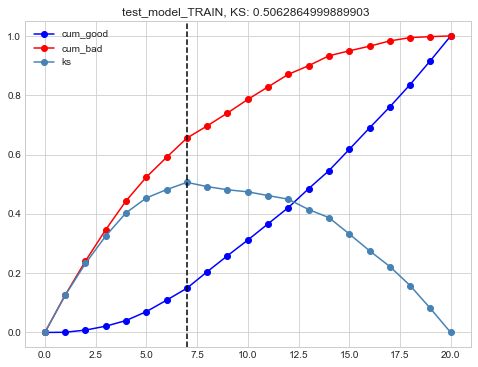

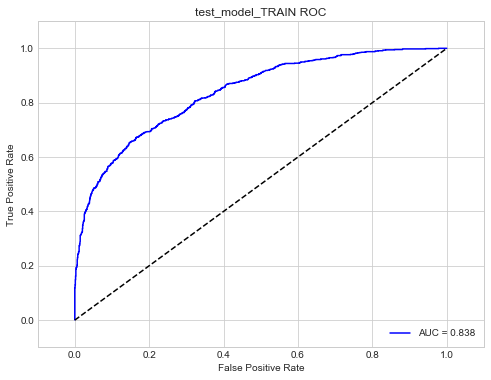

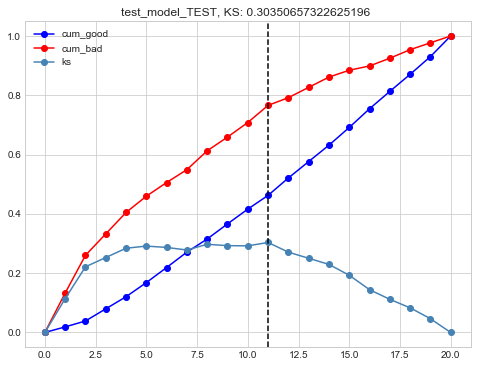

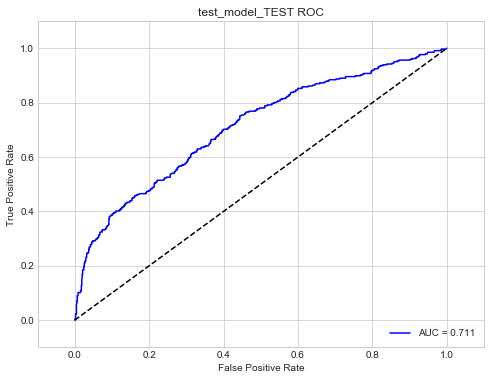

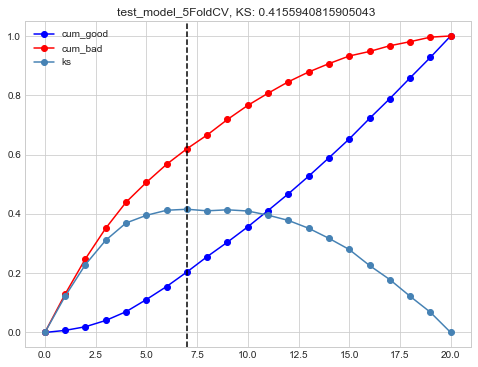

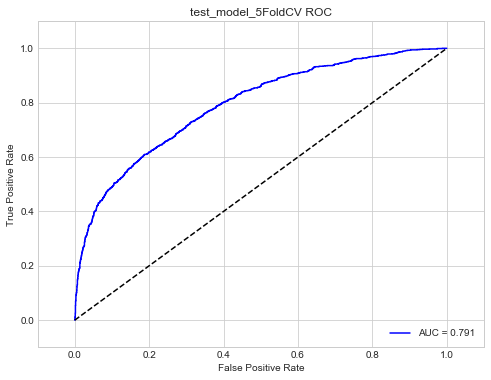

In [767]:
Logistics_model_obj.plot_for_the_model(result_path, Logistics_model_result, with_test=True)

In [850]:
corr = X_transformed_train[to_keep].corr()
corr

,ly_pre_18,jxl_pre_95,xy_pre,monthlyincome,education,age_marital,ty_riskcode_6
ly_pre_18,1.000000,0.313516,0.307572,0.053801,0.056409,0.037705,0.026800
jxl_pre_95,0.313516,1.000000,0.151105,0.025323,0.012345,0.038604,-0.006382
xy_pre,0.307572,0.151105,1.000000,0.062226,0.074288,-0.007424,0.052647
monthlyincome,0.053801,0.025323,0.062226,1.000000,0.096221,-0.023591,-0.009309
education,0.056409,0.012345,0.074288,0.096221,1.000000,0.006476,0.044423
age_marital,0.037705,0.038604,-0.007424,-0.023591,0.006476,1.000000,-0.007418
ty_riskcode_6,0.026800,-0.006382,0.052647,-0.009309,0.044423,-0.007418,1.000000


In [851]:
coefficients = Logistics_model_result['model_final'].params\
.to_frame('beta').reset_index().rename(columns={'index':'var_code'})

In [852]:
coefficients

,var_code,beta
0,const,-0.425374
1,ly_pre_18,0.846922
2,jxl_pre_95,0.740734
3,xy_pre,0.527007
4,monthlyincome,0.904348
5,education,0.895998
6,age_marital,1.012182
7,ty_riskcode_6,0.696971


In [853]:
cleaned_woe = woe_iv_df_coarse.loc[woe_iv_df_coarse[u'指标英文'].isin(coefficients.var_code), [u'指标英文', u'分箱', 'N', u'分布占比', 'WOE', u'逾期率', u'Bad分布占比']]
cleaned_woe.head()

,指标英文,分箱,N,分布占比,WOE,逾期率,Bad分布占比
0,education,"(-inf, -1.0]",2,0.000883,0.451985,0.500000,0.0011
1,education,"(-1.0, 2.0]",532,0.234982,-0.351912,0.315789,0.1873
2,education,"(2.0, 3.0]",1170,0.516784,0.040665,0.405983,0.5295
3,education,"(3.0, inf]",560,0.247350,0.227941,0.451786,0.2821
20,monthlyincome,"(-inf, -1.0]",2,0.000883,0.451985,0.500000,0.0011


In [854]:
score_card = mt.Performance().calculate_score(coefficients, cleaned_woe, 'var_score', var_dict)
score_card.to_excel(os.path.join(result_path,'score_card_v2.xlsx'))

In [185]:
"""
decile
"""

'\ndecile\n'

In [855]:
score_card = pd.read_excel(os.path.join(result_path,'score_card_v2.xlsx'))

In [856]:
selected2 = [i for i in coefficients.var_code if i != 'const']
train_score = mt.Performance().calculate_score_by_scrd(X_cat_train[selected2], score_card)
test_score = mt.Performance().calculate_score_by_scrd(X_cat_test[selected2], score_card)

In [857]:
# 训练集
ks_decile_train = mt.Performance().calculate_ks_by_decile(train_score[1], np.array(y_train), 'decile', q=10)
ks_decile_train

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(478.0, 543.0]",235,13,222,0.944681,0.247492,0.009510,0.247492,0.009510,0.2380,0.1
1,"(543.0, 575.0]",227,44,183,0.806167,0.204013,0.032187,0.451505,0.041697,0.4098,0.2
2,"(575.0, 594.0]",233,101,132,0.566524,0.147157,0.073884,0.598662,0.115582,0.4831,0.8
3,"(594.0, 609.0]",213,124,89,0.417840,0.099220,0.090710,0.697882,0.206291,0.4916,1.4
4,"(609.0, 621.0]",234,149,85,0.363248,0.094760,0.108998,0.792642,0.315289,0.4774,1.8
5,"(621.0, 633.0]",242,168,74,0.305785,0.082497,0.122897,0.875139,0.438186,0.4370,2.3
6,"(633.0, 644.0]",210,153,57,0.271429,0.063545,0.111924,0.938685,0.550110,0.3886,2.7
7,"(644.0, 657.0]",225,200,25,0.111111,0.027871,0.146306,0.966555,0.696416,0.2701,8.0
8,"(657.0, 673.0]",225,200,25,0.111111,0.027871,0.146306,0.994426,0.842721,0.1517,8.0
9,"(673.0, 730.0]",220,215,5,0.022727,0.005574,0.157279,1.000000,1.000000,0.0000,43.0


In [858]:
# 测试集
point_bounds = mt.BinWoe().obtain_boundaries(ks_decile_train[u'分箱'])['cut_boundaries']
ks_decile_test = mt.Performance().calculate_ks_by_decile(test_score[1], np.array(y_test), 'decile', \
                                                         manual_cut_bounds=point_bounds)
ks_decile_test

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 543.0]",111,27,84,0.756757,0.242775,0.029867,0.242775,0.029867,0.2129,0.3
1,"(543.0, 575.0]",114,63,51,0.447368,0.147399,0.069690,0.390173,0.099558,0.2906,1.2
2,"(575.0, 594.0]",161,118,43,0.267081,0.124277,0.130531,0.514451,0.230088,0.2844,2.7
3,"(594.0, 609.0]",168,120,48,0.285714,0.138728,0.132743,0.653179,0.362832,0.2903,2.5
4,"(609.0, 621.0]",141,101,40,0.283688,0.115607,0.111726,0.768786,0.474558,0.2942,2.5
5,"(621.0, 633.0]",144,116,28,0.194444,0.080925,0.128319,0.849711,0.602876,0.2468,4.1
6,"(633.0, 644.0]",117,103,14,0.119658,0.040462,0.113938,0.890173,0.716814,0.1734,7.4
7,"(644.0, 657.0]",121,104,17,0.140496,0.049133,0.115044,0.939306,0.831858,0.1074,6.1
8,"(657.0, 673.0]",102,89,13,0.127451,0.037572,0.098451,0.976879,0.930310,0.0466,6.8
9,"(673.0, inf]",71,63,8,0.112676,0.023121,0.069690,1.000000,1.000000,0.0000,7.9


In [859]:
mt.Performance().calculate_ks_by_decile(test_score[1], np.array(y_test), 'decile', q=10).sort_values('分箱')

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(477.0, 548.0]",125,34,91,0.728000,0.263006,0.037611,0.263006,0.037611,0.2254,0.4
1,"(548.0, 579.0]",130,79,51,0.392308,0.147399,0.087389,0.410405,0.125000,0.2854,1.5
2,"(579.0, 593.0]",124,90,34,0.274194,0.098266,0.099558,0.508671,0.224558,0.2841,2.6
3,"(593.0, 606.0]",121,85,36,0.297521,0.104046,0.094027,0.612717,0.318584,0.2941,2.4
4,"(606.0, 616.0]",133,97,36,0.270677,0.104046,0.107301,0.716763,0.425885,0.2909,2.7
5,"(616.0, 626.0]",120,93,27,0.225000,0.078035,0.102876,0.794798,0.528761,0.2660,3.4
6,"(626.0, 637.0]",128,102,26,0.203125,0.075145,0.112832,0.869942,0.641593,0.2283,3.9
7,"(637.0, 649.0]",119,109,10,0.084034,0.028902,0.120575,0.898844,0.762168,0.1367,10.9
8,"(649.0, 664.0]",129,109,20,0.155039,0.057803,0.120575,0.956647,0.882743,0.0739,5.4
9,"(664.0, 720.0]",121,106,15,0.123967,0.043353,0.117257,1.000000,1.000000,0.0000,7.1


In [750]:
(12+9)/(103+72)

0.12

In [751]:
(103+72)/1250

0.14

In [481]:
(13+17)/(124+124)

0.12096774193548387

In [482]:
(124+124)/1250

0.1984